## Датасет взят из открытых источников (kaggle. com/shrutimechlearn/churn-modelling)

In [ ]:
# Отключить предупреждения
import warnings
warnings.filterwarnings('ignore')
# Библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import plotly
import plotly.graph_objs as go
from plotly.offline import *
from sklearn.tree import export_graphviz
from subprocess import call
from sklearn.model_selection import GridSearchCV
%matplotlib inline
from pylab import *
from sklearn.metrics import *
# Классификаторы
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier, plot_tree

In [2]:
# Файл df содержит датасет банка B
df = pd.read_csv('Churn_Modelling.csv', delimiter=',')
print (
    "Клиентов: ",df.shape[0],"\n",
    "Атрибутов: ",df.shape[1],"\n"
)

df.head(5)

Клиентов:  10000 
 Атрибутов:  14 



,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# Информация о входных данных, проверка на пустые значения и тип атрибутов, использовании памяти
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


In [4]:
# Количество уникальных значений каждого признака
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

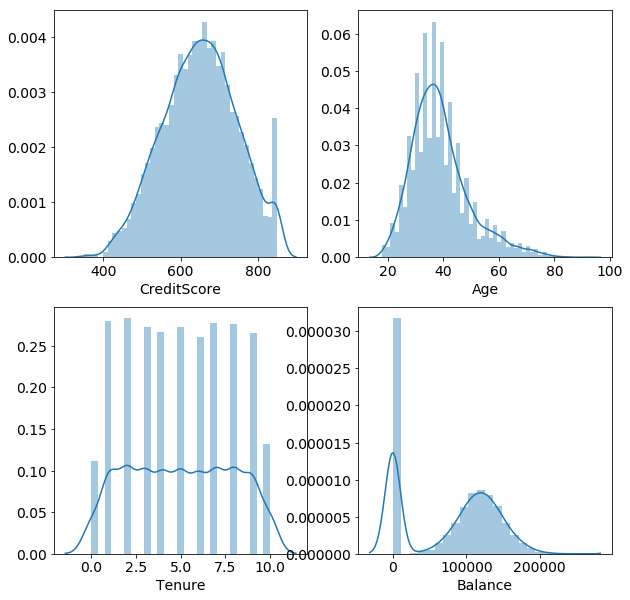

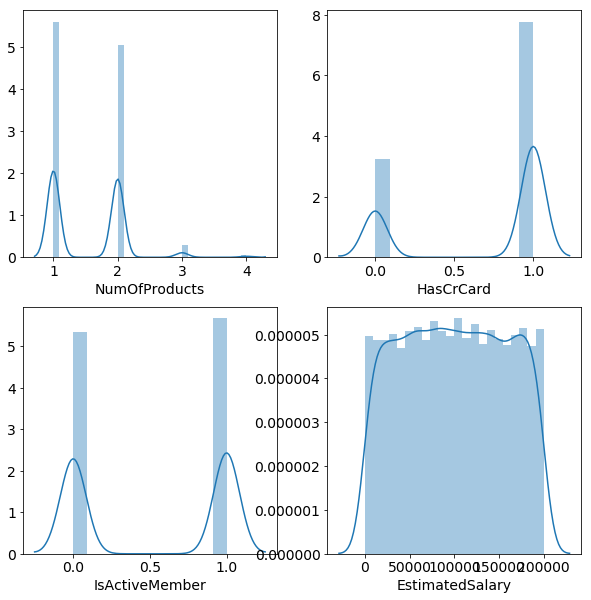

In [3]:
plt.rcParams['font.size'] = 14.0
# Графики признаков
figure, location = plt.subplots(2, 2, figsize=(10, 10))
sns.distplot(df[df.columns[3]], ax=location[0][0])
sns.distplot(df[df.columns[6]], ax=location[0][1])
sns.distplot(df[df.columns[7]], ax=location[1][0])
sns.distplot(df[df.columns[8]], ax=location[1][1])
figure, location = plt.subplots(2, 2, figsize=(10, 10))
sns.distplot(df[df.columns[9]], ax=location[0][0])
sns.distplot(df[df.columns[10]], ax=location[0][1])
sns.distplot(df[df.columns[11]], ax=location[1][0])
sns.distplot(df[df.columns[12]], ax=location[1][1])

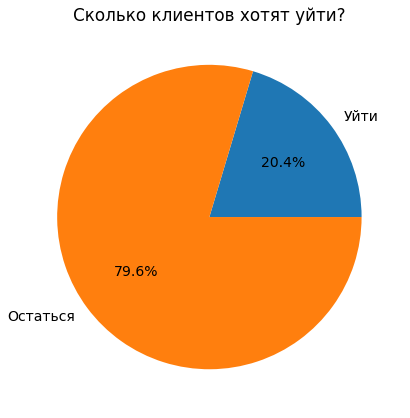

In [79]:
# Круговая диаграмма лояльности клиентов банка
figure, location = plt.subplots(figsize=(7, 7))
labels = ['Уйти', 'Остаться']
sizes = [df['Exited'].mean(axis=0), 1-df['Exited'].mean(axis=0)]
plt.title("Сколько клиентов хотят уйти?")
location.pie(sizes, labels=labels, autopct='%.1f%%')
plt.show()

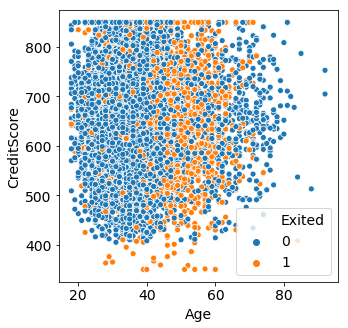

In [12]:
# Лояльность клиентов в зависимости от признаков
_, ax =  plt.subplots(2, 2, figsize=(10,10))
sns.swarmplot(x = "NumOfProducts", y = "Age", hue="Exited", sizes = (20, 20), data = df[:], ax=ax[0][0])
sns.swarmplot(x = "IsActiveMember", y = "Age", hue="Exited", sizes = (20, 20), data = df[:], ax=ax[0][1])

sns.scatterplot(x = "Age", y = "Balance", hue = "Exited", sizes = (20, 20), data = df[:], ax=ax[1][0])
sns.scatterplot(x = "Age", y = "CreditScore", hue = "Exited", sizes = (20, 20), data = df[:], ax=ax[1][1])

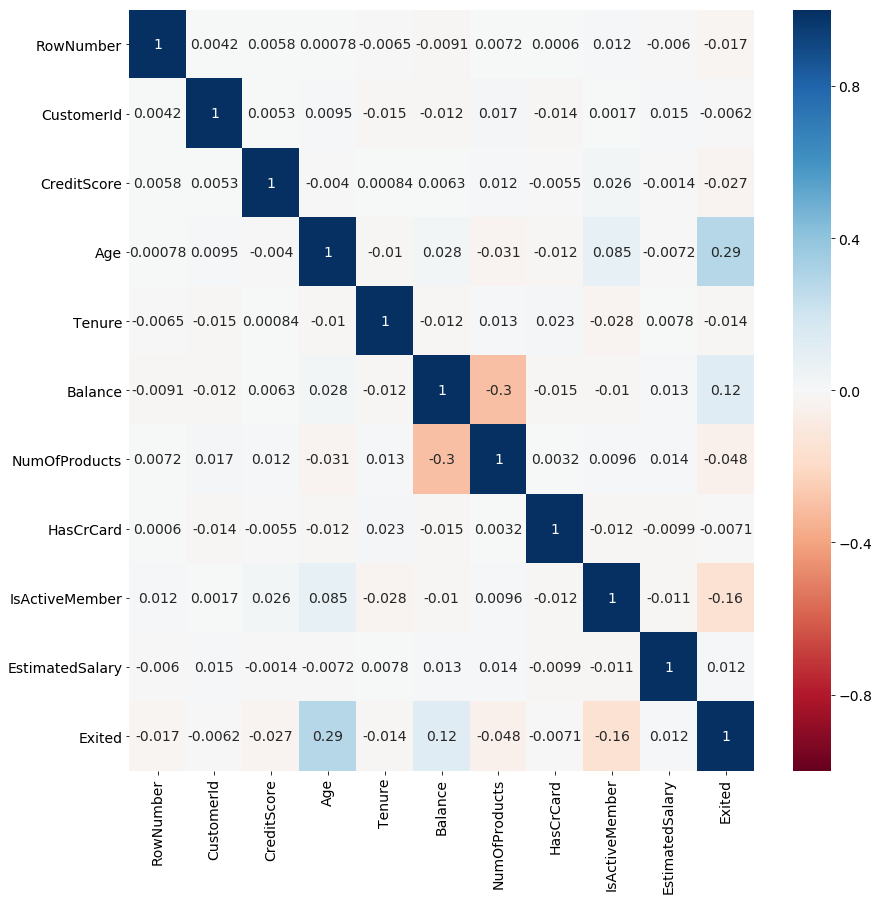

In [82]:
# Матрица корреляции
plt.subplots(figsize=(14,14))
sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='RdBu')

In [4]:
# Преобразование категориальных переменных в числовые
le = LabelEncoder()
le.fit(df.Geography)
df['Geography']=le.transform(df.Geography)

le.fit(df.Gender)
df['Gender']=le.transform(df.Gender)
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [10]:
# Средние значения для клиентов, которые ушли (1) и не ушли (0)
print(round(df[df['Exited'] == 1].mean(),2), "\n\n",
      round(df[df['Exited'] == 0].mean(),2)
     )

RowNumber              4905.92
CustomerId         15690051.96
CreditScore             645.35
Geography                 0.81
Gender                    0.44
Age                      44.84
Tenure                    4.93
Balance               91108.54
NumOfProducts             1.48
HasCrCard                 0.70
IsActiveMember            0.36
EstimatedSalary      101465.68
Exited                    1.00
dtype: float64 

 RowNumber              5024.69
CustomerId         15691167.88
CreditScore             651.85
Geography                 0.73
Gender                    0.57
Age                      37.41
Tenure                    5.03
Balance               72745.30
NumOfProducts             1.54
HasCrCard                 0.71
IsActiveMember            0.55
EstimatedSalary       99738.39
Exited                    0.00
dtype: float64


In [5]:
# Лепестковая диаграмма
data_row = [
    go.Scatterpolar(
      r = [df.CreditScore[df['Exited'] == 1].mean()/(df.CreditScore[df['Exited'] == 1].mean() + df.CreditScore[df['Exited'] == 0].mean()),
           df.Geography[df['Exited'] == 1].mean()/(df.Geography[df['Exited'] == 1].mean()+ df.Geography[df['Exited'] == 0].mean()),
           df.Gender[df['Exited'] == 1].mean()/(df.Gender[df['Exited'] == 1].mean() + df.Gender[df['Exited'] == 0].mean()),
           df.Age[df['Exited'] == 1].mean()/(df.Age[df['Exited'] == 1].mean()+df.Age[df['Exited'] == 0].mean()),
           df.Tenure[df['Exited'] == 1].mean()/(df.Tenure[df['Exited'] == 1].mean()+df.Tenure[df['Exited'] == 0].mean()),
           df.Balance[df['Exited'] == 1].mean()/(df.Balance[df['Exited'] == 1].mean() + df.Balance[df['Exited'] == 0].mean()),
           df.NumOfProducts[df['Exited'] == 1].mean()/(df.NumOfProducts[df['Exited'] == 1].mean() + df.NumOfProducts[df['Exited'] == 0].mean()),
           df.HasCrCard[df['Exited'] == 1].mean()/(df.HasCrCard[df['Exited'] == 1].mean() + df.HasCrCard[df['Exited'] == 0].mean()),
           df.IsActiveMember[df['Exited'] == 1].mean()/(df.IsActiveMember[df['Exited'] == 1].mean()+ df.IsActiveMember[df['Exited'] == 0].mean()),
           df.EstimatedSalary[df['Exited'] == 1].mean()/(df.EstimatedSalary[df['Exited'] == 1].mean() + df.EstimatedSalary[df['Exited'] == 0].mean())],
      
        theta = [df.columns[3],df.columns[4],df.columns[5],df.columns[6],df.columns[7],df.columns[8],df.columns[9],df.columns[10],df.columns[11],df.columns[12]],
        fill = 'toself',
        name = 'Клиент не остался',
        line =  dict(
            color = 'blue'
        )
    ),
    go.Scatterpolar(
      r = [df.CreditScore[df['Exited'] == 0].mean()/(df.CreditScore[df['Exited'] == 1].mean() + df.CreditScore[df['Exited'] == 0].mean()),
           df.Geography[df['Exited'] == 0].mean()/(df.Geography[df['Exited'] == 1].mean()+ df.Geography[df['Exited'] == 0].mean()),
           df.Gender[df['Exited'] == 0].mean()/(df.Gender[df['Exited'] == 1].mean() + df.Gender[df['Exited'] == 0].mean()),
           df.Age[df['Exited'] == 0].mean()/(df.Age[df['Exited'] == 1].mean()+df.Age[df['Exited'] == 0].mean()),
           df.Tenure[df['Exited'] == 0].mean()/(df.Tenure[df['Exited'] == 1].mean()+df.Tenure[df['Exited'] == 0].mean()),
           df.Balance[df['Exited'] == 0].mean()/(df.Balance[df['Exited'] == 1].mean() + df.Balance[df['Exited'] == 0].mean()),
           df.NumOfProducts[df['Exited'] == 0].mean()/(df.NumOfProducts[df['Exited'] == 1].mean() + df.NumOfProducts[df['Exited'] == 0].mean()),
           df.HasCrCard[df['Exited'] == 0].mean()/(df.HasCrCard[df['Exited'] == 1].mean() + df.HasCrCard[df['Exited'] == 0].mean()),
           df.IsActiveMember[df['Exited'] == 0].mean()/(df.IsActiveMember[df['Exited'] == 1].mean()+ df.IsActiveMember[df['Exited'] == 0].mean()),
           df.EstimatedSalary[df['Exited'] == 0].mean()/(df.EstimatedSalary[df['Exited'] == 1].mean() + df.EstimatedSalary[df['Exited'] == 0].mean())],
        
        theta = [df.columns[3],df.columns[4],df.columns[5],df.columns[6],df.columns[7],df.columns[8],df.columns[9],df.columns[10],df.columns[11],df.columns[12]],
        fill = 'toself',
        name = 'Клиент остался',
        line =  dict(
            color = 'green'
        )
    )
]

layout = go.Layout(
  polar = dict(
    radialaxis = dict(
        color = 'darkorange',
      visible = True,
      range = [0, 1]
    )
  ),
  showlegend = True
)

fig = go.Figure(data=data_row, layout=layout)
plotly.offline.plot(fig, filename='Bank_B.html')

'Bank_B.html'

In [12]:
# Минимальные и максимальные значения признаков в датасете
print(df.apply(np.min), "\n\n",
      df.apply(np.max)
     )

RowNumber                 1
CustomerId         15565701
Surname               Abazu
CreditScore             350
Geography                 0
Gender                    0
Age                      18
Tenure                    0
Balance                   0
NumOfProducts             1
HasCrCard                 0
IsActiveMember            0
EstimatedSalary       11.58
Exited                    0
dtype: object 

 RowNumber             10000
CustomerId         15815690
Surname              Zuyeva
CreditScore             850
Geography                 2
Gender                    1
Age                      92
Tenure                   10
Balance              250898
NumOfProducts             4
HasCrCard                 1
IsActiveMember            1
EstimatedSalary      199992
Exited                    1
dtype: object


In [5]:
# Обучающая и тестовая выборки
df = df.drop(columns=["RowNumber", "CustomerId", "Surname"], axis = 1) # Удалить столбцы
df_train = df.sample(frac=0.7)
df_test = df.drop(df_train.index)
print("Обучающая выборка: ", len(df_train),"\n", "Тестовая выборка: ",len(df_test))
df.head(5)

Обучающая выборка:  7000 
 Тестовая выборка:  3000


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [6]:
# Группировка признаков по типу переменной
necateg_p = ['CreditScore','Geography','Gender','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']
df_train = df_train[['Exited'] + necateg_p]
df_train.head(5)

,Exited,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
3766,0,584,2,1,36,4,82696.09,2,0,0,83058.14
6477,0,549,0,0,34,4,0.00,2,0,0,139463.57
2338,0,537,0,1,37,3,0.00,2,1,1,20603.32
6339,0,644,0,0,24,8,92760.55,1,1,0,35896.75
9230,0,582,1,1,35,8,121309.17,2,1,1,28750.67


In [7]:
# Нормализация переменных (от 0 до 1)
minVec = df_train[necateg_p].min().copy()
maxVec = df_train[necateg_p].max().copy()
df_train[necateg_p] = (df_train[necateg_p]-minVec)/(maxVec-minVec)
df_train.head(5)

,Exited,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
3766,0,0.468,1.0,1.0,0.243243,0.4,0.346898,0.333333,0.0,0.0,0.415354
6477,0,0.398,0.0,0.0,0.216216,0.4,0.000000,0.333333,0.0,0.0,0.697463
2338,0,0.374,0.0,1.0,0.256757,0.3,0.000000,0.333333,1.0,1.0,0.102989
6339,0,0.588,0.0,0.0,0.081081,0.8,0.389117,0.000000,1.0,0.0,0.179478
9230,0,0.464,0.5,1.0,0.229730,0.8,0.508874,0.333333,1.0,1.0,0.143737


In [8]:
# Функция для проверки данных
def Df_score(df_predict,df_train_Cols,minVec,maxVec):
    # Численные признаки для обучения модели
    necateg_p = ['CreditScore','Geography','Gender','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']
    df_predict = df_predict[['Exited'] + necateg_p]
    L = list(set(df_train_Cols) - set(df_predict.columns))
    for l in L:
        df_predict[str(l)] = -1        
    df_predict[necateg_p] = (df_predict[necateg_p]-minVec)/(maxVec-minVec)
    df_predict = df_predict[df_train_Cols]
    return df_predict

In [9]:
# Функция для определения оптимальных параметров и метрики
def best_model(model):
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method); 
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2); 
    return (auc_score, fpr_df, tpr_df)

In [10]:
from time import time
# Классификатор Random Forest
parameter_grid = {
            'n_estimators': [100,200,500],
            'max_depth': [8,10,12,14]
        }
clf = RandomForestClassifier() # Классификатор
# Выбор гиперапаметров
grid_searcher = GridSearchCV(clf, parameter_grid, verbose=0, cv=5)
start = time()
# Обучение модели
grid_searcher.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
finish = time()
clf_best = grid_searcher.best_estimator_
print (best_model(grid_searcher))
print("Время работы алгоритма: ", round(finish - start), " секунд")
RForest=clf_best

0.8664285714285714
{'max_depth': 14, 'n_estimators': 200}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
None


In [11]:
y = df_train.Exited
X = df_train.loc[:, df_train.columns != 'Exited']

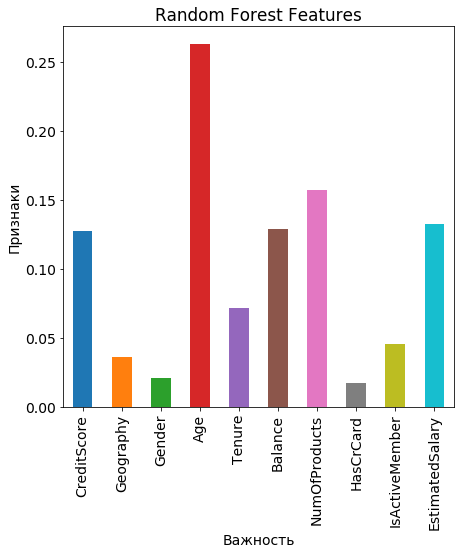

In [22]:
# График важности признаков
features_value = pd.DataFrame({'features': RForest.feature_importances_, 'value': X.columns})
features_value.plot(kind='bar', x='value', y='features', figsize=(7, 7), legend=False)
plt.title('Random Forest Features')
plt.ylabel('Признаки')
plt.xlabel('Важность')
plt.show()

In [27]:
print ("Признаки: ", RForest.feature_importances_, "\n", "Сумма: ", RForest.feature_importances_.sum())

Признаки:  [0.06094455 0.0358407  0.01746758 0.36388331 0.02728306 0.08482404
 0.26293199 0.00599763 0.08643082 0.05439632] 
 Сумма:  1.0


In [26]:
# Метрики
print(classification_report(df_train.Exited,  RForest.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5575
           1       1.00      0.86      0.92      1425

   micro avg       0.97      0.97      0.97      7000
   macro avg       0.98      0.93      0.95      7000
weighted avg       0.97      0.97      0.97      7000



In [27]:
auc_RForest, fpr_RForest, tpr_RForest = get_auc_scores(y, RForest.predict(X),RForest.predict_proba(X)[:,1])

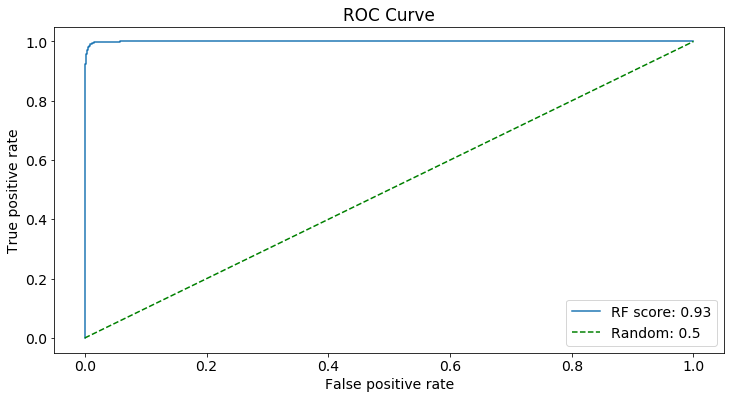

In [31]:
# AUCROC метрика
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_RForest, tpr_RForest, label = 'RF score: ' + str(round(auc_RForest,2)))
plt.plot([0,1], [0,1], 'g--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [14]:
# Классификатор CatBoost
parameter_grid = {
            'iterations': [100,200,500],
            'depth': [8,10,12,14],
            'verbose': [False],
            }
CTB = CatBoostClassifier(learning_rate=0.03) # Классификатор
# Выбор гиперапаметров
grid_searcher = GridSearchCV(CTB, parameter_grid, cv=5)
start = time()
# Обучение модели
grid_searcher.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
finish = time()
CTB_best = grid_searcher.best_estimator_
print (best_model(grid_searcher))
print("Время работы алгоритма: ", round(finish - start), " секунд")
CatBoost=CTB_best

0.8644285714285714
{'depth': 8, 'iterations': 200, 'verbose': False}
None


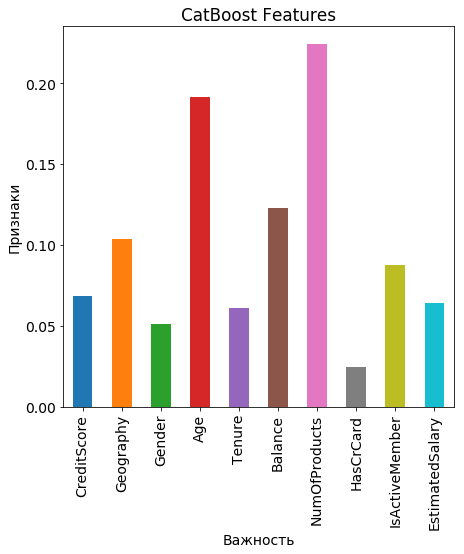

In [24]:
# График важности признаков
features_value = pd.DataFrame({'features': CatBoost.feature_importances_/100, 'value': X.columns}) # Нормализация
features_value.plot(kind='bar', x='value', y='features', figsize=(7, 7), legend=False)
plt.title('CatBoost Features')
plt.ylabel('Признаки')
plt.xlabel('Важность')
plt.show()

In [19]:
print ("Признаки: ", CatBoost.feature_importances_/100, "\n", "Сумма: ", CatBoost.feature_importances_.sum()/100)

Признаки:  [0.02893387 0.10975635 0.03073885 0.2392091  0.02239957 0.12300623
 0.32695727 0.00322344 0.08660287 0.02917247] 
 Сумма:  1.0000000000000002


In [32]:
# Метрики
print(classification_report(df_train.Exited,  CatBoost.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      5575
           1       0.89      0.56      0.69      1425

   micro avg       0.90      0.90      0.90      7000
   macro avg       0.89      0.77      0.81      7000
weighted avg       0.90      0.90      0.89      7000



In [33]:
auc_CatBoost, fpr_CatBoost, tpr_CatBoost = get_auc_scores(y, CatBoost.predict(X),CatBoost.predict_proba(X)[:,1])

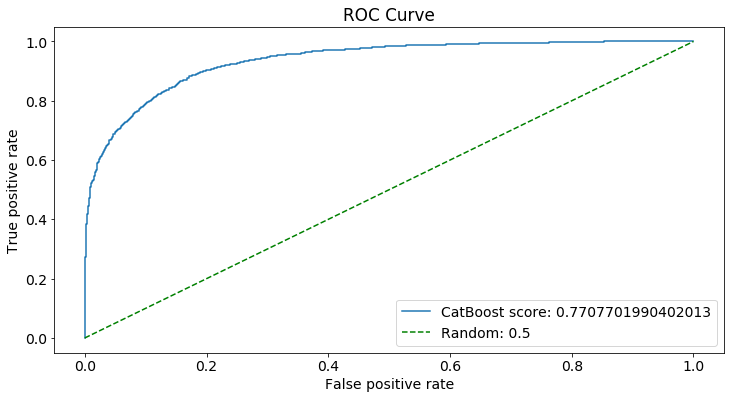

In [34]:
# AUCROC метрика
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_CatBoost, tpr_CatBoost, label = 'CatBoost score: ' + str(auc_CatBoost))
plt.plot([0,1], [0,1], 'g--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [16]:
# Классификатор XGBoost
parameter_grid = {
    'n_estimators':[100,200,500],
    'max_depth': [8,10,12,14],
        }
XGB = XGBClassifier() # Классификатор
# Выбор гиперапаметров
grid_searcher = GridSearchCV(XGB, parameter_grid, verbose=0, cv=5, refit=True)
start = time()
# Обучение модели
grid_searcher.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
finish = time()
XGB_best = grid_searcher.best_estimator_
print (best_model(grid_searcher))
print("Время работы алгоритма: ", round(finish - start), " секунд")
XGboosting=XGB_best

0.8635714285714285
{'max_depth': 8, 'n_estimators': 100}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
None


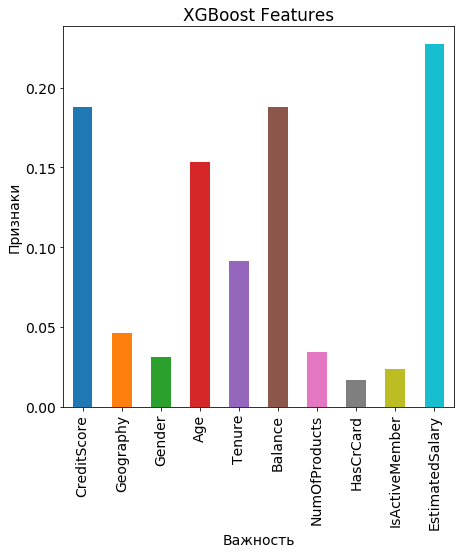

In [35]:
# График важности признаков
features_value = pd.DataFrame({'features': XGboosting.feature_importances_, 'value': X.columns})
features_value.plot(kind='bar', x='value', y='features', figsize=(7, 7), legend=False)
plt.title('XGBoost Features')
plt.ylabel('Признаки')
plt.xlabel('Важность')
plt.show()

In [36]:
print ("Признаки: ", XGboosting.feature_importances_, "\n", "Сумма: ", XGboosting.feature_importances_.sum())

Признаки:  [0.18780422 0.04651163 0.0312331  0.15359654 0.09126555 0.18793942
 0.03434289 0.0164954  0.02366144 0.22714981] 
 Сумма:  1.0


In [37]:
# Метрики
print(classification_report(df_train.Exited,  XGboosting.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5575
           1       0.97      0.76      0.85      1425

   micro avg       0.95      0.95      0.95      7000
   macro avg       0.95      0.87      0.91      7000
weighted avg       0.95      0.95      0.94      7000



In [38]:
auc_XGboosting, fpr_XGboosting, tpr_XGboosting = get_auc_scores(y, XGboosting.predict(X),XGboosting.predict_proba(X)[:,1])

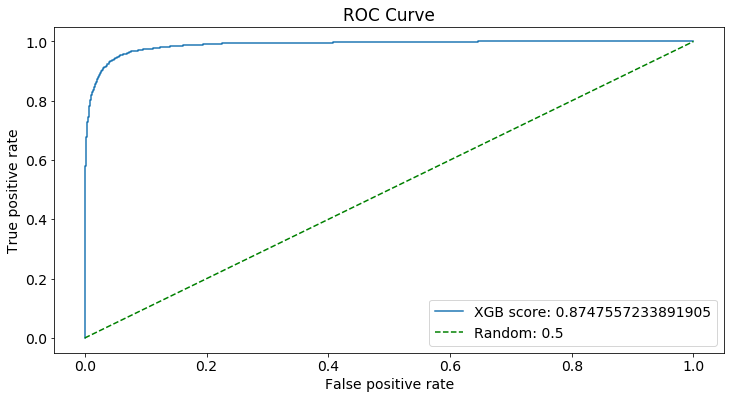

In [39]:
# AUCROC метрика
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_XGboosting, tpr_XGboosting, label = 'XGB score: ' + str(auc_XGboosting))
plt.plot([0,1], [0,1], 'g--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [40]:
# Тестовая выборка
df_test = Df_score(df_test,df_train.columns,minVec,maxVec)
df_test = df_test.mask(np.isinf(df_test))
df_test = df_test.dropna()
print (
    "Клиентов: ",df_test.shape[0],"\n",
    "Атрибутов: ",df_test.shape[1],"\n"
)

df_test.head(5)

Клиентов:  3000 
 Атрибутов:  11 



,Exited,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
6,0,0.944,0.0,1.0,0.432432,0.7,0.000000,0.333333,1.0,1.0,0.050271
13,0,0.398,0.0,0.0,0.094595,0.5,0.000000,0.333333,0.0,0.0,0.954509
14,0,0.570,1.0,0.0,0.229730,0.7,0.000000,0.333333,1.0,1.0,0.329796
16,1,0.606,0.5,1.0,0.540541,0.1,0.556249,0.000000,1.0,0.0,0.025438
17,0,0.398,1.0,0.0,0.081081,0.9,0.000000,0.333333,1.0,1.0,0.071995


In [41]:
# Метрики
print(classification_report(df_test.Exited,  RForest.predict(df_test.loc[:, df_test.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2388
           1       0.73      0.42      0.53       612

   micro avg       0.85      0.85      0.85      3000
   macro avg       0.80      0.69      0.72      3000
weighted avg       0.84      0.85      0.83      3000



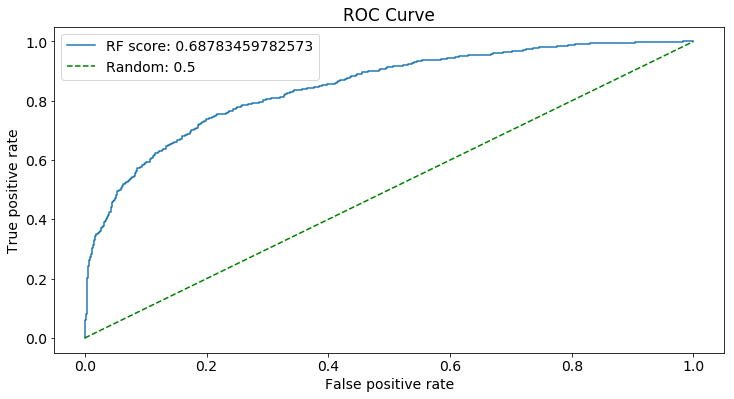

In [42]:
# AUCROC метрика
auc_RForest_test, fpr_RForest_test, tpr_RForest_test = get_auc_scores(df_test.Exited, RForest.predict(df_test.loc[:, df_test.columns != 'Exited']),
                                                       RForest.predict_proba(df_test.loc[:, df_test.columns != 'Exited'])[:,1])
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_RForest_test, tpr_RForest_test, label = 'RF score: ' + str(auc_RForest_test))
plt.plot([0,1], [0,1], 'g--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [43]:
# Метрика Accuracy
accuracy_score(df_test.Exited, RForest.predict(df_test.loc[:, df_test.columns != 'Exited']))

0.8493333333333334

In [45]:
# Метрики
print(classification_report(df_test.Exited, CatBoost.predict(df_test.loc[:, df_test.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2388
           1       0.75      0.44      0.55       612

   micro avg       0.85      0.85      0.85      3000
   macro avg       0.81      0.70      0.73      3000
weighted avg       0.84      0.85      0.84      3000



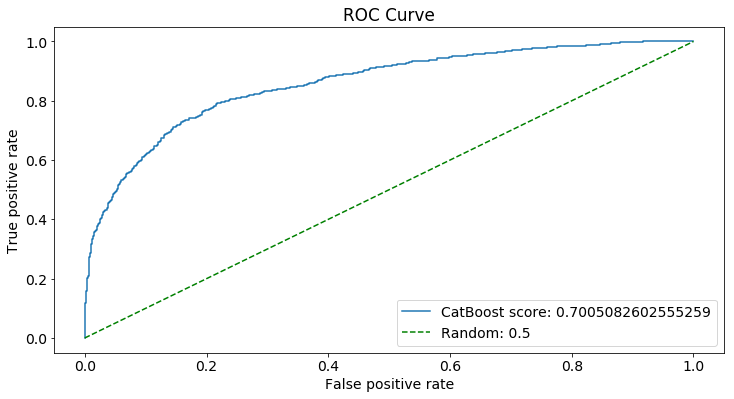

In [46]:
# AUCROC метрика
auc_CatBoost_test, fpr_CatBoost_test, tpr_CatBoost_test = get_auc_scores(df_test.Exited, CatBoost.predict(df_test.loc[:, df_test.columns != 'Exited']),
                                                       CatBoost.predict_proba(df_test.loc[:, df_test.columns != 'Exited'])[:,1])
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_CatBoost_test, tpr_CatBoost_test, label = 'CatBoost score: ' + str(auc_CatBoost_test))
plt.plot([0,1], [0,1], 'g--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [47]:
# Метрика Accuracy
accuracy_score(df_test.Exited, CatBoost.predict(df_test.loc[:, df_test.columns != 'Exited']))

0.855

In [49]:
# Метрики
print(classification_report(df_test.Exited,  XGboosting.predict(df_test.loc[:, df_test.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2388
           1       0.71      0.46      0.56       612

   micro avg       0.85      0.85      0.85      3000
   macro avg       0.79      0.71      0.74      3000
weighted avg       0.84      0.85      0.84      3000



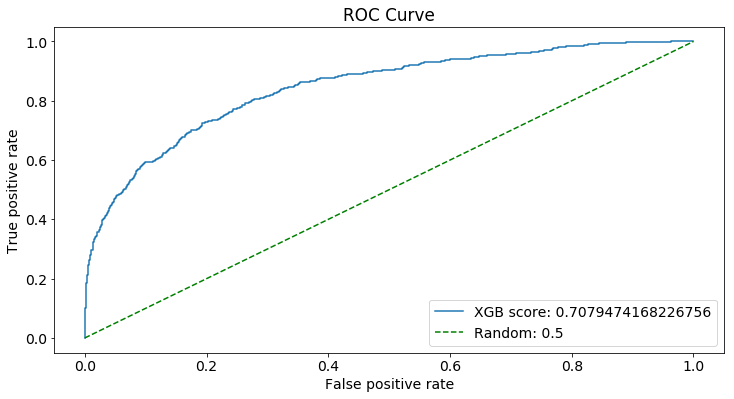

In [50]:
# AUCROC метрика
auc_XGboosting_test, fpr_XGboosting_test, tpr_XGboosting_test = get_auc_scores(df_test.Exited, XGboosting.predict(df_test.loc[:, df_test.columns != 'Exited']),
                                                       XGboosting.predict_proba(df_test.loc[:, df_test.columns != 'Exited'])[:,1])
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_XGboosting_test, tpr_XGboosting_test, label = 'XGB score: ' + str(auc_XGboosting_test))
plt.plot([0,1], [0,1], 'g--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [51]:
# Метрика Accuracy
accuracy_score(df_test.Exited, XGboosting.predict(df_test.loc[:, df_test.columns != 'Exited']))

0.8523333333333334

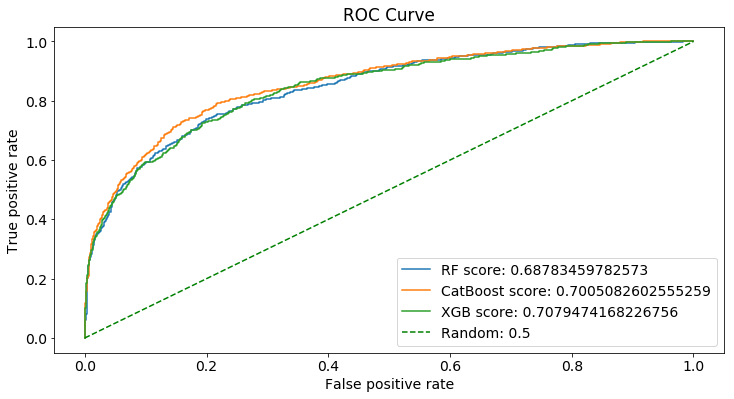

In [53]:
# Сравнение результатов работы программы
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_RForest_test, tpr_RForest_test, label = 'RF score: ' + str(auc_RForest_test))
plt.plot(fpr_CatBoost_test, tpr_CatBoost_test, label = 'CatBoost score: ' + str(auc_CatBoost_test))
plt.plot(fpr_XGboosting_test, tpr_XGboosting_test, label = 'XGB score: ' + str(auc_XGboosting_test))
plt.plot([0,1], [0,1], 'g--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [43]:
# Вывод результатов в 2 столбца
def print2 ( *args ):
    num = len(args)
    x = 0
    while x < num:
        try:
            print(str(int(args[x])) + " " + str(int(args[x + 1])))
        except:
            print(str(int(args[x])))
        x += 2

In [44]:
# Экспорт в txt
import sys
sys.stdout = open('Bank_B_RF.txt', 'w')
print2(*df_test.Exited[:], *RForest.predict(df_test.loc[:, df_test.columns != 'Exited'][:]))
sys.stdout.close()

In [45]:
# Экспорт в txt
sys.stdout = open('Bank_B_CB.txt', 'w')
print2(*df_test.Exited[:], *CatBoost.predict(df_test.loc[:, df_test.columns != 'Exited'][:]))
sys.stdout.close()

In [46]:
# Экспорт в txt
sys.stdout = open('Bank_B_XGB.txt', 'w')
print2(*df_test.Exited[:], *XGboosting.predict(df_test.loc[:, df_test.columns != 'Exited'][:]))
sys.stdout.close()